In [123]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_context('poster')
sns.set_color_codes("muted")

In [2]:
from langdetect import detect_langs
import pycountry as pc
import ujson as json
import itertools as it
import functools as ft
from tqdm import tqdm

In [3]:
with open("/media/jakob/bigdata/train/SB.json", 'rb') as cat_file:
    catalog = json.load(cat_file)

In [4]:
prediction = dict()
for page in tqdm(catalog['pages']):
    text_lines = [line['text'] for line in page['lines']]
    text = ''.join(text_lines) 
    if (len(text) > 0):
        page['languages'] = detect_langs(text)
        prediction[page['path']] =  page['languages']

100%|██████████| 4432/4432 [00:55<00:00, 80.54it/s]


In [131]:
with open("/media/jakob/bigdata/train/SB_lang.json", 'wb') as cat_file:
    json.dump(catalog, cat_file, ensure_ascii=False,indent=2, escape_forward_slashes=False)

# Plots

In [5]:
print detect_langs("Das ist ein Test")
print detect_langs("This ist nicht wirklich a test")

[de:0.999995484313]
[en:0.571426110365, de:0.428573889634]


In [6]:
def append(langs, lang): 
    langs.extend(lang)
    return langs
lang_probs = [(lang.lang, lang.prob) for lang in ft.reduce(append, prediction.values(), list())]

In [15]:
language_count = sorted([(pc.languages.get(iso639_1_code=key).name, (list(group)))
for key, group in it.groupby(sorted(lang_probs), lambda lang: lang[0])], key=lambda lang: lang[1])

In [8]:
counts = [ n for lang, n in language_count]
langs  = [ lang for lang, n in language_count]

In [130]:
lang_data = pd.DataFrame(lang_probs, columns=['lang', 'prob'])
lang_sum = lang_data.groupby('lang').sum()
lang_sum.index = lang_sum.index.map(lambda key: pc.languages.get(iso639_1_code=key).name)
lang_sum.sort_values('prob',ascending=False, inplace=True)
lang_sum.head()
# lang_sum.index

,prob
German,2871.956103
English,613.658885
French,316.392781
Italian,232.394948
Catalan,74.663225


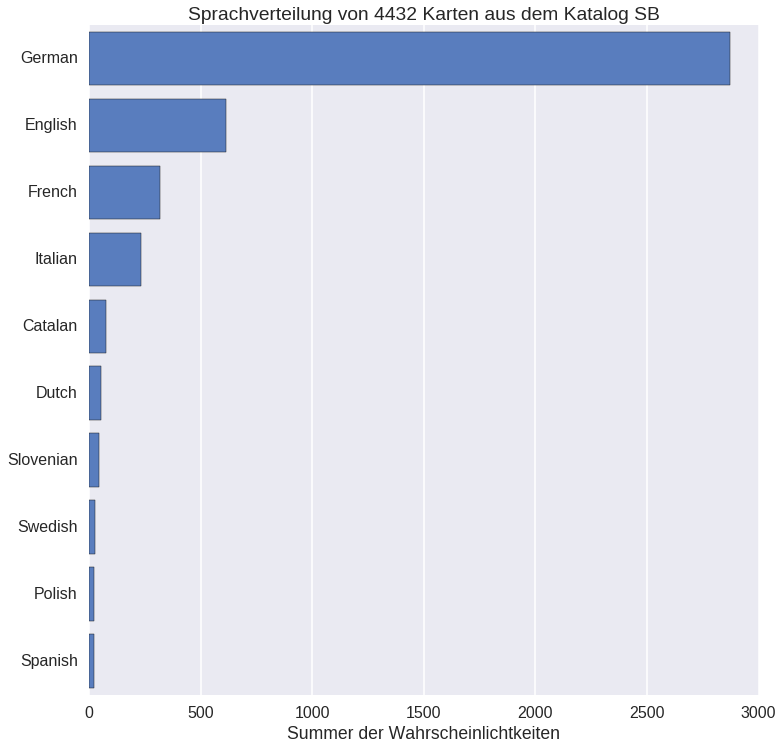

In [131]:
fig = plt.figure(figsize=(12, 12), dpi=300)
g = sns.barplot(data=lang_sum[:10], x='prob', y=lang_sum.index[:10], color='b')
g.axes.set(xlabel='Summer der Wahrscheinlichtkeiten')
g.set_title("Sprachverteilung von {} Karten aus dem Katalog {}".format(len(catalog['pages']), catalog['name']))
fig.savefig('../plots/sprachverteilung.pdf')